In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
trade = pd.read_csv('UN_GlobalSpiceTrade.csv')

In [45]:
trade.head(20)

,country,year,commodity,flow,USD,kg,quat_name,quant
0,Afghanistan,2016,"Tea, green (unfermented) in packages < 3 kg",Import,44819548.0,28093001.0,Weight in kilograms,28093001.0
1,Afghanistan,2016,"Tea, black (fermented or partly) in packages <...",Import,44851687.0,23509706.0,Weight in kilograms,23509706.0
2,Afghanistan,2016,Mate,Export,2436431.0,2204973.0,Weight in kilograms,2204973.0
3,Afghanistan,2016,Coriander seeds,Export,458385.0,223854.0,Weight in kilograms,223854.0
4,Afghanistan,2016,Cumin seeds,Export,24003685.0,5924356.0,Weight in kilograms,5924356.0
5,Afghanistan,2016,Saffron,Export,3868724.0,2402.0,Weight in kilograms,2402.0
6,Afghanistan,2016,Spices nes,Export,60363.0,3982.0,Weight in kilograms,3982.0
7,Afghanistan,2015,"Tea, green (unfermented) in packages < 3 kg",Import,51338067.0,32447158.0,Weight in kilograms,32447158.0
8,Afghanistan,2015,"Tea, black (fermented or partly) in packages <...",Import,77686841.0,39914377.0,Weight in kilograms,39914377.0
9,Afghanistan,2015,Mate,Export,10561370.0,9333753.0,Weight in kilograms,9333753.0


In [56]:
# Try using replace on commodity names to make it simpler
# https://python-forum.io/Thread-pandas-dataframe-replace-regex

trade.filter(regex='^Tea', axis=0)


""
0
1
2
3
4
5
6
7
8
9


In [4]:
trade.columns = ['country', 'year', 'commodity', 'flow', 'USD', 'kg', 'quat_name', 'quant']

In [5]:
trade.describe()

,year,USD,kg,quant
count,84123.000000,8.412300e+04,8.364300e+04,8.384600e+04
mean,2011.807128,1.238754e+07,3.713998e+06,3.713736e+06
std,3.109353,1.488183e+08,5.431667e+07,5.427358e+07
min,2007.000000,1.370904e-01,0.000000e+00,0.000000e+00
25%,2009.000000,8.362500e+03,1.518000e+03,1.511250e+03
50%,2012.000000,9.910400e+04,2.261213e+04,2.255700e+04
75%,2014.000000,1.050370e+06,2.559645e+05,2.555408e+05
max,2017.000000,1.179541e+10,5.693435e+09,5.693435e+09


In [38]:
trade['country'].value_counts()

Canada                   1104
USA                       954
New Zealand               890
China, Hong Kong SAR      869
France                    844
Luxembourg                815
Fiji                      746
Mauritius                 738
Jordan                    717
China                     712
Other Asia, nes           710
South Africa              706
Slovakia                  702
Australia                 701
Indonesia                 701
United Kingdom            695
Italy                     694
Bahrain                   690
Malaysia                  651
Sri Lanka                 651
Trinidad and Tobago       643
Saudi Arabia              643
Estonia                   643
Thailand                  639
Switzerland               636
Belgium                   636
Poland                    636
Germany                   636
EU-28                     636
Spain                     636
                         ... 
Andorra                   179
Syria                     164
Fmr Sudan 

In [6]:
cmdty = trade['commodity'].value_counts().index.sort_values()
cmdty

Index(['Anise or badian seeds',
       'Capsicum or Pimenta, dried, crushed or ground', 'Caraway seeds',
       'Cardamoms', 'Cinnamon and cinnamon-tree flowers crushed or ground',
       'Cinnamon and cinnamon-tree flowers whole',
       'Cloves (whole fruit, cloves and stems)', 'Coffee husks and skins',
       'Coffee substitutes containing coffee',
       'Coffee, not roasted, decaffeinated',
       'Coffee, not roasted, not decaffeinated',
       'Coffee, roasted, decaffeinated', 'Coffee, roasted, not decaffeinated',
       'Coriander seeds', 'Cumin seeds', 'Curry',
       'Fennel seeds, juniper berries', 'Ginger', 'Mace', 'Mate',
       'Mixtures of spices', 'Nutmeg',
       'Pepper of the genus Piper, crushed or ground',
       'Pepper of the genus Piper, whole', 'Saffron', 'Spices nes',
       'Tea, black (fermented or partly) in packages < 3 kg',
       'Tea, black (fermented or partly) in packages > 3 kg',
       'Tea, green (unfermented) in packages < 3 kg',
       'Tea, gree

In [ ]:
coffee = cmdty.loc[cmdty['commodity'] == 'Coffee substitutes containing coffee'].sum()

In [10]:
# Seperate out the export and import data
exports = trade[trade['flow'] == 'Export']
imports = trade[trade['flow'] == 'Import']

In [43]:
# Group export data by country, commodity, & year
all_export = exports.groupby(['country', 'commodity', 'year'])['USD'].sum()
all_export

country      commodity                                            year
Afghanistan  Coriander seeds                                      2008      888030.0
                                                                  2009       72994.0
                                                                  2010       64890.0
                                                                  2011      122328.0
                                                                  2015      632598.0
                                                                  2016      458385.0
             Cumin seeds                                          2008      883870.0
                                                                  2009     5688412.0
                                                                  2010     6244635.0
                                                                  2011     2992380.0
                                                                  2012    54147

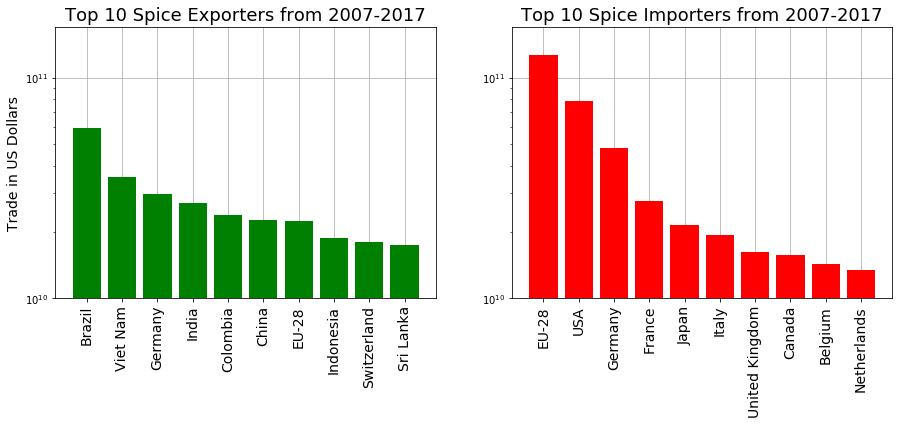

In [15]:
# Cumulative exports by country between 2007-2017 & top ten list
cnty_ex = exports.groupby('country')['USD'].sum()
cnty_topex = cnty_ex.nlargest(10, 'first')

# Cumulative imports by country between 2007-2017 & top ten list
cnty_im = imports.groupby('country')['USD'].sum()
cnty_topim = cnty_im.nlargest(10, 'first')

# Plot top 10 exporters & importers
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(cnty_topex.index, cnty_topex, log=True, zorder=10, color='g')
plt.title('Top 10 Spice Exporters from 2007-2017', fontsize=18)
plt.ylabel('Trade in US Dollars', fontsize=14)
plt.ylim(10**10, 10.5**11)
plt.xticks(rotation='vertical', fontsize=14)
plt.grid(zorder=0)

plt.subplot(1,2,2)
plt.bar(cnty_topim.index, cnty_topim, log=True, zorder=10, color='r')
plt.title('Top 10 Spice Importers from 2007-2017', fontsize=18)
plt.ylim(10**10, 10.5**11)
plt.xticks(rotation='vertical', fontsize=14)
plt.grid(zorder=0)
#plt.show()

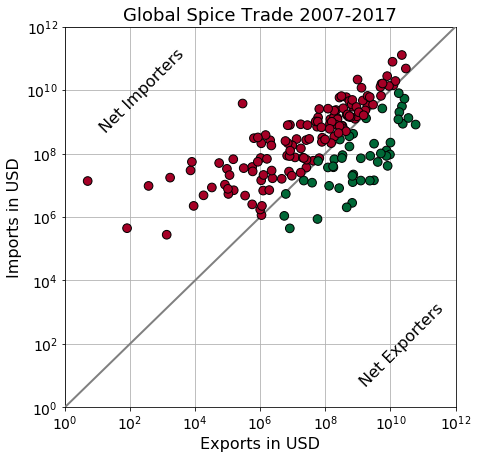

In [17]:
# Creating new DataFrame with exports and imports at the country level and adding a Trade Surplus column
cnty_trade = pd.DataFrame({'USDex': cnty_ex, 'USDim': cnty_im}).fillna(0)
cnty_trade['surplus'] = cnty_trade['USDex'] - cnty_trade['USDim']


# Normalized colormap variable for plot
surplus = cnty_trade['surplus']
normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

# Scatter plot of exports & imports for all countries
plt.figure(figsize=(7,7))
plt.scatter(cnty_trade['USDex'], 
            cnty_trade['USDim'], 
            zorder=10, 
            s=75, 
            edgecolors='k',
            c=surplus, 
            cmap='RdYlGn', 
            norm=normalize
           )
plt.plot((0,10**12), (0,10**12), c='gray', linewidth=2, zorder=5)
plt.title('Global Spice Trade 2007-2017', fontsize=18)
plt.xlabel('Exports in USD', fontsize=16)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.xlim(1, 1000000000000)
plt.ylabel('Imports in USD', fontsize=16)
plt.yscale('log')
plt.yticks(fontsize=14)
plt.ylim(1, 1000000000000)
plt.text(10, 10**11, 'Net Importers', rotation=45, fontsize=16)
plt.text(10**9, 1000, 'Net Exporters', rotation=45, fontsize=16)
plt.grid(zorder=0)
plt.show()

In [19]:
num_deficit = cnty_trade['surplus'][cnty_trade['surplus'] <= 0].count()
num_surplus = cnty_trade['surplus'][cnty_trade['surplus'] > 0].count()
print('{} countries have a cumulative spice trade surplus.'.format(num_surplus))
print('{} countries have a cumulative spice trade deficit.'.format(num_deficit))

48 countries have a cumulative spice trade surplus.
144 countries have a cumulative spice trade deficit.


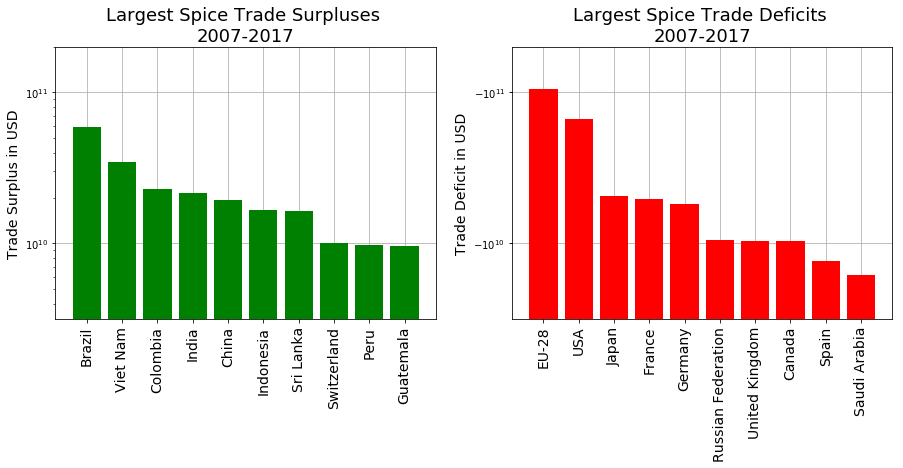

In [20]:
# Creating series of largest surplus and deficit countries
tenbigsurp = cnty_trade['surplus'].nlargest(10)
tenbigdef = cnty_trade['surplus'].nsmallest(10)

# Plotting surplus & deficit countries
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.bar(tenbigsurp.index, tenbigsurp, color='g', zorder=10)
plt.title('Largest Spice Trade Surpluses \n2007-2017', fontsize=18)
plt.ylabel('Trade Surplus in USD', fontsize=14)
plt.yscale('log')
plt.ylim(10**9.5, 10**11.3)
plt.xticks(rotation='vertical', fontsize=14)
plt.grid(zorder=0)

plt.subplot(1,2,2)
plt.bar(tenbigdef.index, tenbigdef, color='r', zorder=10)
plt.title('Largest Spice Trade Deficits \n2007-2017', fontsize=18)
plt.ylabel('Trade Deficit in USD', fontsize=14)
plt.yscale('symlog')
plt.ylim(-10**9.5, -10**11.3)
plt.xticks(rotation='vertical', fontsize=14)
plt.grid(zorder=0)
plt.show()

In [40]:
# Brazil's top 5 spice export commodities
brazil_ex = exports[exports['country'] == 'Brazil'
                   ].groupby('commodity')['USD'].sum().sort_values(ascending=False)[:5]
brazil_ex

commodity
Coffee, not roasted, not decaffeinated    5.579624e+10
Pepper of the genus Piper, whole          2.170024e+09
Mate                                      7.809458e+08
Cloves (whole fruit, cloves and stems)    2.274372e+08
Coffee, roasted, not decaffeinated        2.196853e+08
Name: USD, dtype: float64

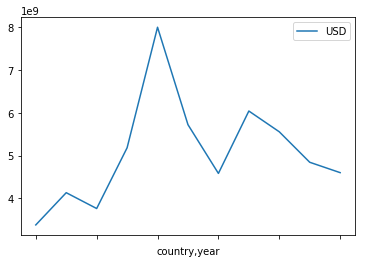

In [25]:
# Annual 'Coffee, not roasted, not decaffeinated' exported, grouped by country & year

# 1.Create list for commodity as variable
# 2.Use For loop to replace commodity in assignment name
# 3.Plot directly from DF
ann_cf_nr_nd_ex = exports[exports['commodity'] == 'Coffee, not roasted, not decaffeinated'
                        ].groupby(['country', 'year'])['USD'].sum()

# Brazil's annual exports of 'Coffee, not roasted, not decaffeinated'
bz_ann_cf_nr_nd_ex = pd.DataFrame(ann_cf_nr_nd_ex).query("country == 'Brazil'")
bz_ann_cf_nr_nd_ex.plot()
plt.show()



In [24]:
# EU's top 5 spice imports
eu_im = imports[imports['country'] == 'EU-28'
               ].groupby('commodity')['USD'].sum().sort_values(ascending=False)[:5]
eu_im

commodity
Coffee, not roasted, not decaffeinated                 9.074314e+10
Coffee, roasted, not decaffeinated                     1.287829e+10
Tea, black (fermented or partly) in packages > 3 kg    5.907820e+09
Pepper of the genus Piper, whole                       3.732060e+09
Capsicum or Pimenta, dried, crushed or ground          2.082344e+09
Name: USD, dtype: float64

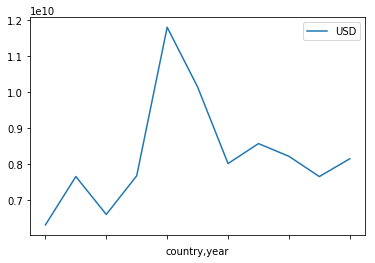

In [27]:
# Annual imports of 'Coffee, not roasted, not decaffeinated', grouped by country and year
ann_cf_nr_nd_im = imports[imports['commodity'] == 'Coffee, not roasted, not decaffeinated'
                        ].groupby(['country', 'year'])['USD'].sum()

# EU's annual imports of 'Coffee, not roasted, not decaffeinated'
eu_ann_cf_nr_nd_im = pd.DataFrame(ann_cf_nr_nd_im).query("country == 'EU-28'")
eu_ann_cf_nr_nd_im.plot()
plt.show()

In [28]:
# Cumulative exports of a commodity from a given country
cmdty_ex = exports.groupby(['commodity', 'country'])['USD'].sum()
cmdty_ex


commodity              country                         
Anise or badian seeds  Albania                             3.755440e+05
                       Algeria                             1.061828e+04
                       Argentina                           2.968191e+05
                       Armenia                             2.110000e+02
                       Aruba                               7.206701e+01
                       Australia                           8.828438e+05
                       Austria                             1.949963e+07
                       Azerbaijan                          1.875200e+04
                       Bahrain                             3.644200e+04
                       Bangladesh                          4.697990e+05
                       Barbados                            3.560000e+02
                       Belarus                             3.250000e+04
                       Belgium                             7.857639e+06
        

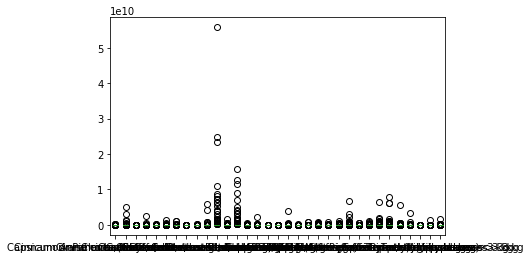

In [33]:
# Playing with the following code from stackoverflow
#df.unstack(level=0).plot(kind='bar', subplots=True)

cmdty_ex.unstack(level=0).plot(kind='box', subplots=False)

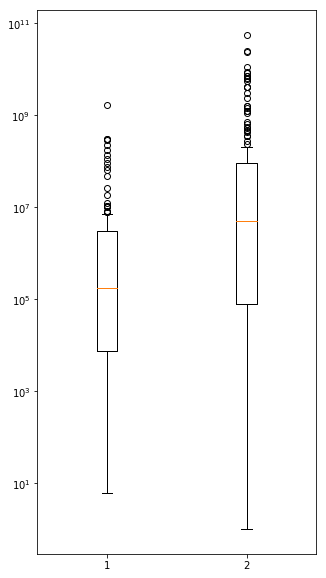

In [29]:
# Cumulative exports of Vanilla & Coffee NR ND
van_ex = pd.DataFrame(cmdty_ex).query("commodity == 'Vanilla beans'")
cf_nr_nd_ex = pd.DataFrame(cmdty_ex).query("commodity == 'Coffee, not roasted, not decaffeinated'")

# Simple boxplot of Vanilla & Coffee NR ND
plt.figure(figsize=(5,10))
plt.boxplot((van_ex['USD'], cf_fr_c['USD']))
plt.yscale('log')
plt.show()

In [30]:
# Top exporter of a given commodity
top_cmdty_ex = cmdty_ex.groupby(level='commodity').nlargest(1).reset_index(level=0, drop=True)
top_cmdty_ex

commodity                                             country    
Anise or badian seeds                                 China          1.961543e+08
Capsicum or Pimenta, dried, crushed or ground         India          5.037103e+09
Caraway seeds                                         Egypt          3.595709e+07
Cardamoms                                             Guatemala      2.386068e+09
Cinnamon and cinnamon-tree flowers crushed or ground  Indonesia      3.902933e+08
Cinnamon and cinnamon-tree flowers whole              Sri Lanka      1.284357e+09
Cloves (whole fruit, cloves and stems)                Madagascar     1.216996e+09
Coffee husks and skins                                EU-28          1.837325e+07
Coffee substitutes containing coffee                  EU-28          1.416662e+08
Coffee, not roasted, decaffeinated                    Germany        6.019072e+09
Coffee, not roasted, not decaffeinated                Brazil         5.579624e+10
Coffee, roasted, decaffeinated  

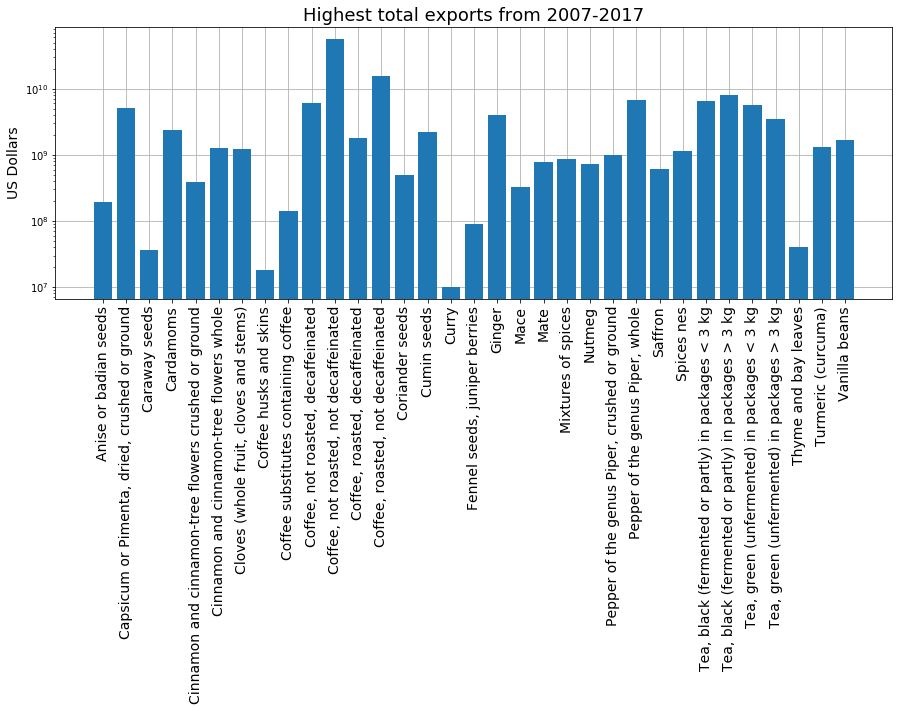

In [31]:
# Mis-labeled plot of top exporter of each commodity
plt.figure(figsize=(15,5))
plt.bar(cmdty, top_cmdty_ex, log=True, zorder=10)
plt.title('Highest total exports from 2007-2017', fontsize=18)
plt.ylabel('US Dollars', fontsize=14)
plt.xticks(rotation='vertical', fontsize=14)
plt.grid(zorder=0)
plt.show()

 1. How to use multiindexed DataFrames efficiently
    - Want to look at look at country- and spice-specific trends through time
        - Brazil coffee exports 
        - EU-28 coffee inports
        - Madagascar vanilla exports
 2. Unsure how to combined the multiple coffee commodity types
 3. ??Find a list of countries with one dominant spice export??